# Assignment 5

This assignment is meant to exercise you on **Clustering**. This assignment will help you understand the details of implementing k-means both in traditional way and in Spark. In addition, this assignment will also help you understand the impact of using different distance metrics and initialization strategies in practice.

To receive credit, answer all questions correctly and submit to Canvas before the deadline.

**This assignment is due Friday, June 4 at 11:59 PM.**

**NOTE: All instructions deserve 0 point. However, -5 for if you do not follow, run, and understand.**

**YOUR FULL NAME (1 POINT)**: Nazim Zerrouki

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the assignment, we ask that you **write your solutions individually**. If you do discuss the assignment with others, please **include their names** below.

**Collaborators**: Shrustishree Sumanth

**Sources:** 

https://cmdlinetips.com/2019/05/k-means-clustering-in-python/#:~:text=K%2Dmeans%20algorithm%20is%20an,one%20K%3D3%20random%20clusters.&text=for%20each%20cluster%20we%20compute%20the%20center%20point%20of%20the%20cluster.

https://github.com/apache/spark/blob/master/examples/src/main/python/kmeans.py

http://vargas-solar.com/big-data-analytics/hands-on/k-means-with-spark-hadoop/

https://cseweb.ucsd.edu/~dasgupta/291-unsup/lec2.pdf

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# Part 1: Introduction

Let us say we have a set $X$ of $n$ data points in the $d$-dimensional space (i.e., $d$ features). Given the number of clusters $k$ and the set of $k$ centroids $C$, we now proceed to define various distance metrics and the corresponding cost functions that they minimize in clustering.

## 1.1 Euclidean Distance

Given two points $A$ and $B$ in $d$ dimensional space such that $A = [a_1, a_2, \cdots, a_d]$ and $B = [b_1, b_2, \cdots, b_d]$, the Euclidean distance between $A$ and $B$ is defined as

\begin{equation}
||A-B||=\sqrt{\sum_{i=1}^d (a_i-b_i)^2}
\end{equation}

The corresponding cost function $\phi$ that is minimized when we assign points to clusters using the Euclidean distance metric is given by

\begin{equation}
\phi = \sum_{x\in X} \min_{c\in C}||x-c||^2
\end{equation}


## 1.2 Manhattan distance

The Manhattan distance between $A$ and $B$ is defined as

\begin{equation}
|A-B| = \sum_{i=1}^d|a_i-b_i|
\end{equation}

The corresponding cost function $\psi$ that is minimized when we assign points to clusters using the Manhattan distance metric is given by

\begin{equation}
\psi =\sum_{x\in X}\min_{c\in C}|x-c|
\end{equation}

## 1.3 Iterative K-Means Algorithm 

We learned the basic k-means algorithm in class which is as follows: $k$ centroids are initialized, each point is assigned to the nearest centroid and the centroids are recomputed based on the assignments of points to clusters. In practice, the above steps are run for several iterations. We present the resulting iterative version of k-means in Algorithm 1.

--------------------------------------------------------

Algorithm 1: Iterative K-Means Algorithm

1. Select $k$ points as initial centroids of the $k$ clusters.

2. for iterations 1 to MAX_ITER do
  * for each point $p$ in the dataset do
      * Assign point $p$ to the cluster with the closest centroid
  * end for
  * for each cluster $c$ do
    * Recompute the centroid of $c$ as the mean of all the data points assigned to $c$
  * end for
3. end for

---------------------------------------------------------

## 1.4 Data and Setup

Please use the dataset in kmeans.zip downloaded from Canvas of A5.

The zip has 3 files:

    1. data.txt contains the dataset which has 4601 rows and 58 columns. Each row is a document represented as a 58 dimensional vector of features. Each component in the vector represents the importance of a word in the document.

    2. c1.txt contains k initial cluster centroids. These centroids were chosen by selecting k = 10 random points from the input data.

    3. c2.txt contains initial cluster centroids which are as far apart as possible using Euclidean distance (i.e., k-means++).

Set number of iterations MAX_ITER=25 and number of clusters $k=10$ for all the following experiments. **Your program should ensure that the correct number of iterations are run.**

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive/data")

In [4]:
data = pd.read_csv('data.txt', sep=' ', header=None)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.00,0.06,0.06,0.0,0.0,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,0.00,1.88,0.00,0.00,0.00,0.00,0.00,0.00,0.62,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.31,0.31,0.31,0.0,0.0,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,0.00,2.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,2.00,0.0,0.0,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.80,0.30,0.00,0.00,0.00,0.00,0.90,1.50,0.00,0.30,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,1.20,0.0,0.0,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.32,0.00,0.00,0.00,0.00,0.00,0.00,1.93,0.00,0.32,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.32,0.00,0.32,0.0,0.0,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


In [5]:
data.shape

(4601, 58)

In [6]:
c1 = pd.read_csv('c1.txt', sep=' ', header=None)
c1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.000,0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0,0.43,0.43,0,0,0,0,0,0,0,0,0.00,0,0,0,0.07,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.132,0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0,1.16,0.06,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.06,0,0,0.12,0.00,0.06,0.06,0,0,0.01,0.143,0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.137,0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.135,0,0.135,0.000,0.000,3.537,40,191,1
5,0.00,0.00,0.00,0,1.85,0.00,0.00,1.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.223,0,0.000,0.000,0.000,3.000,15,54,1
6,0.00,0.00,0.00,0,1.92,0.00,0.00,0.00,0.00,0.64,0.96,1.28,0.00,0.00,0.00,0.96,0.00,0.32,3.85,0.00,0.64,0,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.054,0,0.164,0.054,0.000,1.671,4,112,1
7,0.00,0.00,0.00,0,1.88,0.00,0.00,1.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.206,0,0.000,0.000,0.000,2.450,11,49,1
8,0.15,0.00,0.46,0,0.61,0.00,0.30,0.00,0.92,0.76,0.76,0.92,0.00,0.00,0.00,0.00,0.00,0.15,1.23,3.53,2.00,0,0.00,0.15,0,0,0,0,0,0,0,0,0.15,0,0,0,0.00,0,0,0.00,0,0,0.30,0.00,0.00,0.00,0,0,0.00,0.271,0,0.181,0.203,0.022,9.744,445,1257,1
9,0.06,0.12,0.77,0,0.19,0.32,0.38,0.00,0.06,0.00,0.00,0.64,0.25,0.00,0.12,0.00,0.00,0.12,1.67,0.06,0.71,0,0.19,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.06,0.00,0.00,0,0,0.04,0.030,0,0.244,0.081,0.000,1.729,43,749,1


In [7]:
c1.shape

(10, 58)

In [8]:
c2 = pd.read_csv('c2.txt', sep=' ', header=None)
c2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.00,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.00,0.00,0.00,0.00,0,0.00,0,0.00,0,0,0,0.00,0,0,0.00,0.00,0,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.778,0.000,0.000,3.756,61,278,1
1,0.19,0.00,0.38,0.00,0.00,0.19,0.00,0.00,0.00,0.00,0.19,0.19,0.00,0.00,0.00,0.38,0.00,0.19,1.14,0.00,0.38,0.00,0.00,0.00,0.00,0,0.00,0,0.00,0,0,0,0.00,0,0,0.00,0.00,0,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.010,0.010,0.000,0.000,0.000,0.003,2.383,21,15841,1
2,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0,0.00,0,0,0,0.00,0,0,0.00,0.00,0,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,1.024,9.752,0.003,1.542,1.785,1.998,239.571,9989,10062,1
3,0.29,0.04,0.04,0.00,0.14,0.04,0.00,0.29,0.29,0.94,0.14,0.04,0.14,0.00,0.19,0.04,0.39,0.19,1.60,0.04,0.79,9.53,0.69,0.47,0.00,0,0.00,0,0.00,0,0,0,0.00,0,0,0.04,0.00,0,0.04,0.00,0.00,0.00,0,0.00,0.19,0.00,0.00,0.00,1.117,0.053,0.000,0.356,0.090,0.011,12.332,1171,9163,1
4,0.01,0.01,0.07,0.00,0.05,0.00,0.00,0.01,0.03,0.13,0.05,0.00,0.00,0.05,0.00,0.00,0.01,0.07,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0,0.00,0,0.00,0,0,0,0.07,0,0,0.13,0.00,0,0.00,0.01,0.46,0.00,0,0.03,0.00,0.80,0.01,0.07,0.050,0.301,0.131,0.002,0.090,0.002,2.577,82,5395,0
5,0.20,0.81,0.61,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.40,0.00,0.00,0.00,0.20,0.00,0.00,0.20,0.00,0.20,0.00,0.00,0.40,0.00,0,0.00,0,0.00,0,0,0,0.00,0,0,0.00,0.00,0,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.831,0.338,0.030,1102.500,2204,2205,1
6,0.07,0.00,0.15,0.00,0.09,0.05,0.00,0.03,0.05,0.05,0.00,0.41,0.03,0.00,0.00,0.01,0.09,0.13,0.03,0.01,0.07,0.00,0.01,0.00,0.00,0,0.03,0,0.01,0,0,0,1.21,0,0,0.07,0.95,0,0.01,0.11,0.13,0.01,0,0.00,0.00,0.39,0.03,0.51,0.042,0.173,0.002,0.008,0.005,0.002,2.145,71,2954,0
7,0.33,0.00,1.65,0.00,0.99,0.00,0.33,0.00,0.66,1.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.99,0.66,0.00,0.00,0.00,0.33,0,0.00,0,0.00,0,0,0,0.00,0,0,0.00,0.00,0,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.859,0.101,0.000,337.250,1146,1349,1
8,0.00,0.00,0.46,0.00,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.46,0.93,0.00,0.00,0.00,0.46,0.00,0.00,0,0.00,0,0.00,0,0,0,0.00,0,0,0.15,0.00,0,0.00,0.93,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.071,0.071,0.000,0.095,0.023,0.000,62.750,1505,2761,1
9,0.50,0.25,0.42,0.00,0.08,0.23,0.02,0.35,0.35,0.69,0.21,0.90,0.50,0.92,0.02,0.33,0.42,0.02,3.05,0.00,1.43,0.00,0.94,0.46,0.00,0,0.00,0,0.00,0,0,0,0.00,0,0,0.00,0.00,0,0.00,0.02,0.00,0.00,0,0.00,0.02,0.00,0.02,0.00,0.000,0.069,0.000,0.325,0.523,0.124,6.723,445,4128,1


In [9]:
c2.shape

(10, 58)

In [10]:
dataX = np.array(data.values)
dataX

array([[0.000e+00, 6.400e-01, 6.400e-01, ..., 6.100e+01, 2.780e+02,
        1.000e+00],
       [2.100e-01, 2.800e-01, 5.000e-01, ..., 1.010e+02, 1.028e+03,
        1.000e+00],
       [6.000e-02, 0.000e+00, 7.100e-01, ..., 4.850e+02, 2.259e+03,
        1.000e+00],
       ...,
       [3.000e-01, 0.000e+00, 3.000e-01, ..., 6.000e+00, 1.180e+02,
        0.000e+00],
       [9.600e-01, 0.000e+00, 0.000e+00, ..., 5.000e+00, 7.800e+01,
        0.000e+00],
       [0.000e+00, 0.000e+00, 6.500e-01, ..., 5.000e+00, 4.000e+01,
        0.000e+00]])

In [11]:
c1_X = np.array(c1.values)
c1_X

array([[0.000e+00, 6.400e-01, 6.400e-01, 0.000e+00, 3.200e-01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.400e-01,
        0.000e+00, 0.000e+00, 0.000e+00, 3.200e-01, 0.000e+00, 1.290e+00,
        1.930e+00, 0.000e+00, 9.600e-01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 7.780e-01, 0.000e+00, 0.000e+00,
        3.756e+00, 6.100e+01, 2.780e+02, 1.000e+00],
       [2.100e-01, 2.800e-01, 5.000e-01, 0.000e+00, 1.400e-01, 2.800e-01,
        2.100e-01, 7.000e-02, 0.000e+00, 9.400e-01, 2.100e-01, 7.900e-01,
        6.500e-01, 2.100e-01, 1.400e-01, 1.400e-01, 7.000e-02, 2.800e-01,
        3.470e+00, 0.000e+00, 1.590e+00, 0.000e+00, 4.300e-

In [12]:
len(c1_X)

10

In [13]:
c2_X = np.array(c2.values)
c2_X

array([[0.00000e+00, 6.40000e-01, 6.40000e-01, 0.00000e+00, 3.20000e-01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 6.40000e-01, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        3.20000e-01, 0.00000e+00, 1.29000e+00, 1.93000e+00, 0.00000e+00,
        9.60000e-01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 7.78000e-01, 0.00000e+00, 0.00000e+00, 3.75600e+00,
        6.10000e+01, 2.78000e+02, 1.00000e+00],
       [1.90000e-01, 0.00000e+00, 3.80000e-01, 0.00000e+00, 0.00000e+00,
        1.90000e-01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
   

In [14]:
len(c2_X)

10

# Part 2: Exploring initialization strategies with Euclidean distance

In this part, you are expected to implement the traditional k-means (small-scale version) using the Euclidean distance. **Note: you should implement k-means according to the above introduction by yourself, while you may use python lib for Euclidean distance calculation. There is no constrains on how you implement. Pay close attention on how cost should be calculated.** 

## Question 2.1 [18 points]

Using the Euclidean distance as the distance measure, compute the cost function $\phi(i)$ for every iteration $i$.

For the first iteration, you will be computing the cost function using the initial centroids located in one of the two text files. 

Run your k-means on data.txt using c1.txt and c2.txt separately. Generate a graph where you plot the cost as the number of iterations increases for both c1.txt and c2.txt (e.g., two lines in one graph).

**Your visualization should be easy to follow considering those techniques of visualization we discussed in class.**



             c1            c2
0  6.236603e+08  4.387478e+08
1  5.098629e+08  2.498039e+08
2  4.854807e+08  1.944948e+08
3  4.639970e+08  1.698048e+08
4  4.609693e+08  1.562957e+08


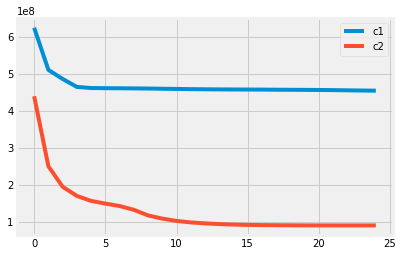

In [15]:
from sklearn.metrics import pairwise_distances_argmin_min
k = len(c1_X)
MAX_ITERS=25

def compute_clusters(centroid):
  clusters = []
  distances = pairwise_distances_argmin_min(dataX, centroid, metric='euclidean')
  clusters = distances[0]
  min = distances[1]
  cost = np.sum([x ** 2 for x in min])
  return clusters, cost

def compute_centroid(centroid):
  clusters, cost = compute_clusters(centroid)
  centroid = data.groupby(clusters).mean()
  return centroid.values, cost

def compute_cost(centroid):
  costs = []
  for j in range(k):
    z = np.mean(centroid[j])
    cost = []
    for x in dataX:
      cost.append(np.square(x-z))
    #costs.append(np.sum(np.array(np.square(x-z) for x in zip(dataX))))
    costs.append(np.min(cost))
  return np.sum(costs)


def k_means(centroid):
  costs = []
  for i in range(MAX_ITERS):
    centroid, cost = compute_centroid(centroid)
    #costs.append(compute_cost(centroid))
    costs.append(cost)
  return costs

def test():
  cost1 = k_means(c1_X)
  print("\n")
  cost2 = k_means(c2_X)
  costs = {
      'c1': cost1,
      'c2': cost2
  }
  df = pd.DataFrame(costs)
  print(df.head())
  df.plot(kind='line')

test()


## Question 2.2 [3 points]

Looking at the cost after 10 iterations, is random initialization of k-means using c1.txt better than initialization using c2.txt? Explain your reasoning on why.

**Your Answer**: The cost in c2.txt is better than the cost in c1.txt because all of the clusters found in c2 are not randomized making it easier to optimize the solution and find data points that are closest to each cluster in the centroid.

I believe this is also because the clusters are all found within a specific radius so-to-speak. Because they are clusters that are farthest away, you will naturally find data points that are closest to each cluster as you optimize the solution.

# Part 3: Exploring initialization strategies with Manhattan distance



## Question 3.1 [9 points]

Similar to Question 2.1, using the Manhattan distance as the distance measure, compute the cost function $\psi(i)$ for every iteration $i$.

For the first iteration, you will be computing the cost function using the initial centroids located in one of the two text files. 

Run your k-means on data.txt using c1.txt and c2.txt separately. Generate a graph where you plot the cost as the number of iterations increases for both c1.txt and c2.txt (e.g., two lines in one graph).

**Your visualization should be easy to follow considering those techniques of visualization we discussed in class.**



              c1            c2
0  550117.142000  1.433739e+06
1  464510.301457  1.084489e+06
2  470930.305803  9.734317e+05
3  483811.426569  8.959346e+05
4  489213.151500  8.651283e+05


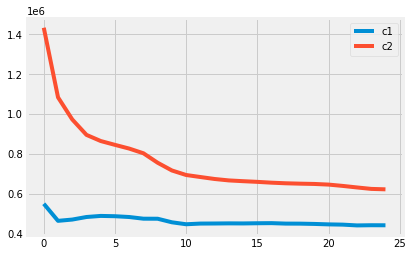

In [16]:
def compute_clusters(centroid):
  clusters = []
  distances = pairwise_distances_argmin_min(dataX, centroid, metric='manhattan')
  clusters = distances[0]
  min = distances[1]
  cost = cost = np.sum(np.absolute(min))
  return clusters, cost

test()


## Question 3.2 [3 points]

Looking at the cost after 10 iterations, is random initialization of k-means using c1.txt better than initialization using c2.txt? Explain your reasoning on why.

**Your Answer**: The initialization of c1.txt is better than the initialization of c2 in this case. Manhattan distance is the sum of all distances from the source to destination. The sum will naturally be the largest for clusters that are found farthest away from the source.

# Part 4: K-Means using MapReduce in Spark

In this part, you will implement k-means using MapReduce in Spark when the data is stored in multiple machines. You may use the following steps as a reference for your implementation.

1. Setup Spark environment as the Spark Example in Lecture. You may define a `SparkContext` as `sc`.

2. Use `sc.textFile()` to load data (data.txt) and both initializations (c1.txt and c2.txt) separately. [HINT: `sc.textFile()` will load data line by line as a string, you may apply `Map` to each line to split those values using space and store them as numerical values in `np.array`]

3. Centroids of c1 and c2 should be collected (`.collect()`) for each Mapper since they are small, while data should not.

4. Use `Map` to assign each data point in each Mapper to the nearest centroid. The cost of each data point can be added using `Map` immediately after the assignment.

5. Use `Reduce` to recompute new centroids that should be collected (`.collect()`) again. [HINT: `Reduce` may calculate the sum of all data points assigned to the same cluster (i.e., the same key). Another 'Map' may be used to calculate the average]

## Question 4.1 [24 points]

Implement Spark k-means using the Euclidean distance as the distance measure, compute the cost function $\phi(i)$ for every iteration $i$ of data.txt for both c1.txt and c2.txt and plot. The plot is expected to be same as Question 2.1.

**Your visualization should be easy to follow considering those techniques of visualization we discussed in class.**

In [17]:
!pip install pyspark

In [18]:
from operator import add
import sys
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
#sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
sc = SparkContext(conf=SparkConf())

In [19]:
data = sc.textFile('data.txt')
for line in data.collect():
  print(line)

0 0.64 0.64 0 0.32 0 0 0 0 0 0 0.64 0 0 0 0.32 0 1.29 1.93 0 0.96 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.778 0 0 3.756 61 278 1
0.21 0.28 0.5 0 0.14 0.28 0.21 0.07 0 0.94 0.21 0.79 0.65 0.21 0.14 0.14 0.07 0.28 3.47 0 1.59 0 0.43 0.43 0 0 0 0 0 0 0 0 0 0 0 0 0.07 0 0 0 0 0 0 0 0 0 0 0 0 0.132 0 0.372 0.18 0.048 5.114 101 1028 1
0.06 0 0.71 0 1.23 0.19 0.19 0.12 0.64 0.25 0.38 0.45 0.12 0 1.75 0.06 0.06 1.03 1.36 0.32 0.51 0 1.16 0.06 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.06 0 0 0.12 0 0.06 0.06 0 0 0.01 0.143 0 0.276 0.184 0.01 9.821 485 2259 1
0 0 0 0 0.63 0 0.31 0.63 0.31 0.63 0.31 0.31 0.31 0 0 0.31 0 0 3.18 0 0.31 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.137 0 0.137 0 0 3.537 40 191 1
0 0 0 0 0.63 0 0.31 0.63 0.31 0.63 0.31 0.31 0.31 0 0 0.31 0 0 3.18 0 0.31 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.135 0 0.135 0 0 3.537 40 191 1
0 0 0 0 1.85 0 0 1.85 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [20]:
data = data.map(lambda line: np.array([float(x) for x in line.split(' ')])).cache()
for x in data.collect():
  print(x)

Streaming output truncated to the last 5000 lines.
 15.38  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.   14.   53.   56.    0.  ]
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   5.   0.   0.   0.   0.   0.   0.   1.75 3.
 7.   0.  ]
[0.000e+00 0.000e+00 1.000e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e-01 0.000e+00 0.000e+00 3.100e-01 5.200e-01 1.000e-01 0.000e+00
 0.000e+00 1.000e-01 1.000e-01 0.000e+00 1.000e-01 0.000e+00 0.000e+00
 0.000e+00 1.000e-01 0.000e+00 3.140e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 5.200e-01 3.100e-01 0.000e+00 0.000e+00 1.000e-01 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 

In [21]:
c1 = np.array(sc.textFile('c1.txt').map(lambda line: np.array([float(x) for x in line.split(' ')])).collect())
print(c1)

[[0.000e+00 6.400e-01 6.400e-01 0.000e+00 3.200e-01 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.400e-01 0.000e+00 0.000e+00
  0.000e+00 3.200e-01 0.000e+00 1.290e+00 1.930e+00 0.000e+00 9.600e-01
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 7.780e-01 0.000e+00 0.000e+00 3.756e+00 6.100e+01
  2.780e+02 1.000e+00]
 [2.100e-01 2.800e-01 5.000e-01 0.000e+00 1.400e-01 2.800e-01 2.100e-01
  7.000e-02 0.000e+00 9.400e-01 2.100e-01 7.900e-01 6.500e-01 2.100e-01
  1.400e-01 1.400e-01 7.000e-02 2.800e-01 3.470e+00 0.000e+00 1.590e+00
  0.000e+00 4.300e-01 4.300e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 7.000e-02 0.000e+00 0.000e+00

In [22]:
c2 = np.array(sc.textFile('c2.txt').map(lambda line: np.array([float(x) for x in line.split(' ')])).collect())
print(c2)

[[0.00000e+00 6.40000e-01 6.40000e-01 0.00000e+00 3.20000e-01 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 6.40000e-01
  0.00000e+00 0.00000e+00 0.00000e+00 3.20000e-01 0.00000e+00 1.29000e+00
  1.93000e+00 0.00000e+00 9.60000e-01 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 7.78000e-01 0.00000e+00 0.00000e+00
  3.75600e+00 6.10000e+01 2.78000e+02 1.00000e+00]
 [1.90000e-01 0.00000e+00 3.80000e-01 0.00000e+00 0.00000e+00 1.90000e-01
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.90000e-01 1.90000e-01
  0.00000e+00 0.00000e+00 0.00000e+00 3.80000e-01 0.00000e+00 1.90000e-01
  1.14000e+00 0.00000e+00 3.80000e-01 0.00000e+00 0.00000e+00

Iteration: 1 Cost C1: 623660345.3064115
Iteration: 1 Cost C2: 438747790.02791756
Iteration: 2 Cost C1: 509862908.2975454
Iteration: 2 Cost C2: 249803933.62600276
Iteration: 3 Cost C1: 485480681.87200826
Iteration: 3 Cost C2: 194494814.40631253
Iteration: 4 Cost C1: 463997011.68501294
Iteration: 4 Cost C2: 169804841.45154318
Iteration: 5 Cost C1: 460969266.5729968
Iteration: 5 Cost C2: 156295748.80627593
Iteration: 6 Cost C1: 460537847.9827684
Iteration: 6 Cost C2: 149094208.10896596
Iteration: 7 Cost C1: 460313099.6535447
Iteration: 7 Cost C2: 142508531.61961532
Iteration: 8 Cost C1: 460003523.8894082
Iteration: 8 Cost C2: 132303869.40652987
Iteration: 9 Cost C1: 459570539.3177352
Iteration: 9 Cost C2: 117170969.83719078
Iteration: 10 Cost C1: 459021103.3422909
Iteration: 10 Cost C2: 108547377.17857003
Iteration: 11 Cost C1: 458490656.1919812
Iteration: 11 Cost C2: 102237203.3179959
Iteration: 12 Cost C1: 457944232.5879751
Iteration: 12 Cost C2: 98278015.74975666
Iteration: 13 Cost C1:

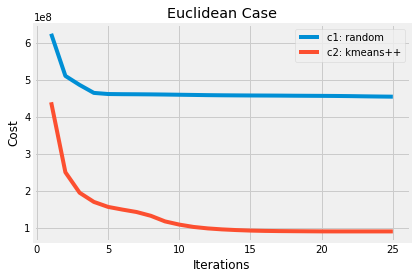

In [23]:
def closest(point, centroid):
  index = 0
  cnt = 0
  min = float('inf')
  for center in centroid:
    dist =  linalg.norm(point-center)
    if min > dist:
      min = dist
      index = cnt
    cnt = cnt+1
  return index
  
costs1 = []
costs2 = []
for i in range(MAX_ITERS):
  cost1 = data.map(lambda point: np.min([linalg.norm(point - center) ** 2 for center in c1]))
  cost2 = data.map(lambda point: np.min([linalg.norm(point - center) ** 2 for center in c2]))
  total1 = cost1.reduce(lambda c1, c2: c1+c2)
  total2 = cost2.reduce(lambda c1, c2: c1+c2)
  total1 = np.sum(total1)
  total2 = np.sum(total2)
  costs1.append(total1)
  costs2.append(total2)
  print("Iteration: " + str(len(costs1)) + " Cost C1: " + str(total1))
  print("Iteration: " + str(len(costs2)) + " Cost C2: " + str(total2))

  centers1 = data.map(lambda point: (closest(point, c1), (point, 1)))
  stats1 = centers1.reduceByKey(lambda p1, p2: (p1[0] + p2[0], p1[1] + p2[1]))
  centers2 = data.map(lambda point: (closest(point, c2), (point, 1)))
  stats2 = centers2.reduceByKey(lambda p1, p2: (p1[0] + p2[0], p1[1] + p2[1]))
  
  newC1 = stats1.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()
  newC2 = stats2.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

  for c in newC1:
    c1[c[0]] = c[1]
  for c in newC2:
    c2[c[0]] = c[1]

x = range(1, MAX_ITERS + 1)
fig, ax = plt.subplots()
ax.plot(x, costs1, label='c1: random')
ax.legend()
ax.plot(x, costs2, label='c2: kmeans++')
ax.legend()
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Euclidean Case')
plt.grid(True)
plt.show()

